In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
tab_count = pd.read_csv("toden/toden_counts.txt", sep="\t")
tab_meta = pd.read_excel("toden/toden_metadata.xlsx")

In [3]:
# Normalization: standard scale

def PreProcessNumerical(df, dfFit, columnNames):
    scaler = StandardScaler()
    scaler.fit(dfFit[columnNames])
    df[columnNames] = scaler.transform(df[columnNames])
    return df

In [4]:
# normalize count data
preTrain = tab_count.copy()
Train = PreProcessNumerical(preTrain, preTrain, preTrain.columns)

In [5]:
# Fill out 'None' in the columns ['Apoe.status','apoe_carrier','apoe_dose']
li = ['Age','Gender','Center','Disease']
share_feat = ['Apoe.status','apoe_carrier','apoe_dose']
estimate_meta = tab_meta[li].copy()
for i in ['Gender','Center','Disease']:
    le = LabelEncoder()
    le.fit(estimate_meta[i])
    estimate_meta[i] = le.transform(tab_meta[i])

share_col = []
for var in share_feat:
    temp = estimate_meta.copy()
    le = LabelEncoder()
    le.fit(tab_meta[var])
    a = le.transform(tab_meta[var])
    if 'None' in le.classes_:
        a = np.where(a==le.transform(['None'])[0], np.nan, a)
    temp[var] = a

    imputer = KNNImputer(n_neighbors=1)
    impute_data = imputer.fit_transform(temp)
    temp = pd.DataFrame(impute_data, columns=['Age','Gender','Center','Disease',var])

    temp[var] = [int(i) for i in temp[var]]
    temp[var] = le.inverse_transform(temp[var])
    share_col.append(list(temp[var]))

In [6]:
# df1: standard-scaled count
# df2: standarad-scaled count + share_feat(apoe status, carrier, dose)

df1 = Train.T
df2 = df1.copy()
for i in range(len(share_feat)):
    le = LabelEncoder()
    le.fit(share_col[i])
    a = le.transform(share_col[i])
    df2[share_feat[i]] = a

In [7]:
import warnings
warnings.filterwarnings('ignore')

y = tab_meta['Disease']
ma = {'NCI': 0, 'AD': 1}
for i in range(len(y)):
    y.iloc[i] = ma[y.iloc[i]]

In [8]:
train_input=['normalized count', 'normalized count + apoe info']
train_data = [df1, df2]
mean_feature_importances = []

for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    feature_importances = []

    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True, random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]

        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(XTrain, list(yTrain))

        pred = clf.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), clf.predict_proba(XVal)[:,1]))

        feature_importances.append(clf.feature_importances_)

    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")
    mean_feature_importances.append(pd.DataFrame(feature_importances, columns=dTrain.columns).mean())
    mean_feature_importances[i] = mean_feature_importances[i].sort_values(ascending=False)

Train: normalized count, mean val AUC: 0.6828221023410794
Train: normalized count + apoe info, mean val AUC: 0.7330423485594053


In [9]:
useful_features_list = []

for i in range(len(mean_feature_importances)):
    features = mean_feature_importances[i][mean_feature_importances[i] > 0]
    useful_features_list.append(features)

print(useful_features_list)

[ENSG00000162817    0.221847
ENSG00000008516    0.064042
ENSG00000126878    0.058888
ENSG00000107902    0.032898
ENSG00000198053    0.026306
                     ...   
ENSG00000179397    0.002259
ENSG00000270423    0.002254
ENSG00000103415    0.002247
ENSG00000277048    0.002247
ENSG00000206203    0.002004
Length: 87, dtype: float64, ENSG00000162817    0.221847
ENSG00000008516    0.064042
ENSG00000126878    0.058888
ENSG00000107902    0.032898
Apoe.status        0.032129
                     ...   
ENSG00000268015    0.002259
ENSG00000143156    0.002259
ENSG00000227531    0.002254
ENSG00000255350    0.002247
ENSG00000261915    0.002004
Length: 85, dtype: float64]


In [10]:
[i for i in useful_features_list[1].index if not i.startswith('ENSG')], \
useful_features_list[0].index[:15].intersection(useful_features_list[1].index[:10])

(['Apoe.status'],
 Index(['ENSG00000162817', 'ENSG00000008516', 'ENSG00000126878',
        'ENSG00000107902', 'ENSG00000160588', 'ENSG00000166825',
        'ENSG00000065485', 'ENSG00000159459', 'ENSG00000129450'],
       dtype='object'))

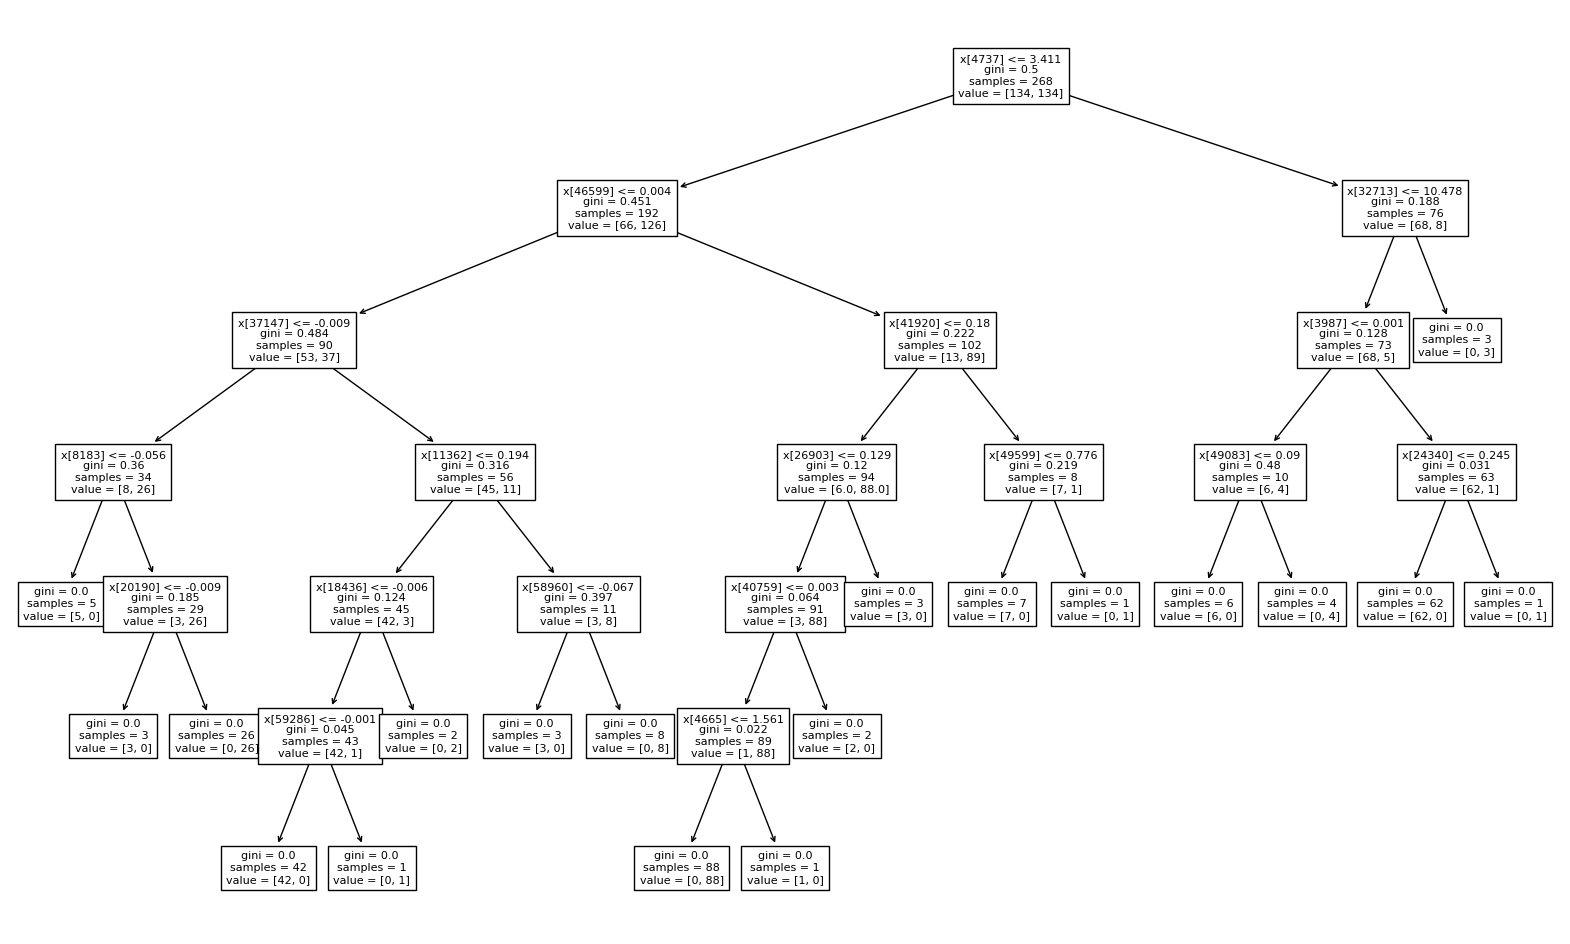

In [11]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [12]:
# GaussianNB approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    feature_importances = []

    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True, random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,].astype(int)

        gnb = GaussianNB()
        gnb.fit(XTrain, yTrain.astype(int))

        pred = gnb.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), gnb.predict_proba(XVal)[:,1]))

        # r = permutation_importance(gnb, XVal, yVal, n_repeats=3, random_state=16)
        # feature_importances.append(r.importances_mean)

    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")
    # mean_perm_importances = pd.DataFrame(feature_importances, columns=dTrain.columns).mean()
    # mean_feature_importances.append(mean_perm_importances.sort_values(ascending=False))

Train: normalized count, mean val AUC: 0.6396282619640521
Train: normalized count + apoe info, mean val AUC: 0.6396282619640521


In [ ]:
for i in range(2, len(mean_feature_importances)):
    features = mean_feature_importances[i][mean_feature_importances[i] > 0]
    useful_features_list.append(features)

print(useful_features_list)

In [9]:
# Validation on other two datasets

tab1 = pd.read_csv("silver_seq/silver_seq_counts.txt", sep="\t")
tab2 = pd.read_csv("burgos_dbgap/burgos_dbgap_counts.txt", sep="\t")
